# Week 10 - Recurrent Neural Networks for time series

## Setup

In [1]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 8)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


#Legacy TF < 2.10
#if not tf.test.is_gpu_available():
#    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
#    if IS_COLAB:
#        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

        
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
        
        
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

1 Physical GPUs, 1 Logical GPU


## Basic RNNs

### Generate the Dataset

The function below generates as many time series as specified in `batch_size`, each of length `n_steps`. All series are univariate, i.e. only one value is produced per time step in each series. The function returns a NumPy array of shape `[batch size, time steps, 1]`. Each series is the addition of two sine waves of fixed amplitudes but random frequency, plus somenoise.

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

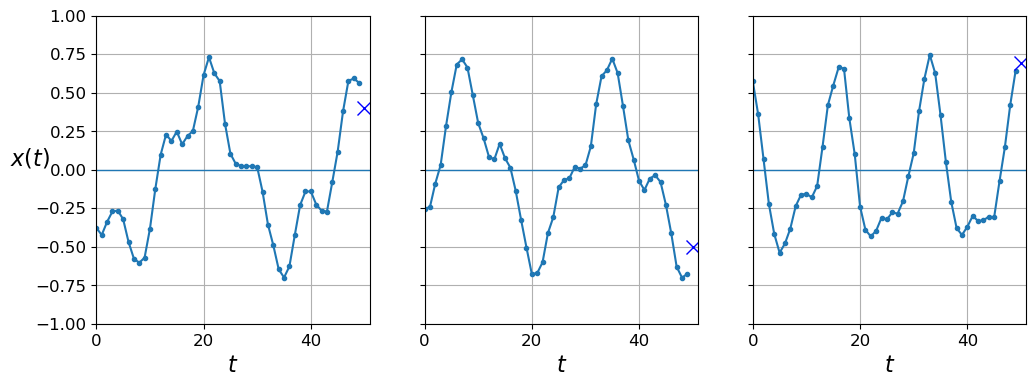

In [8]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### 2. Try some predictors

### 2.1 Naive predictions 
We just predict the last observed value.

In [9]:
y_pred = X_valid[:, -1] # last observed value
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

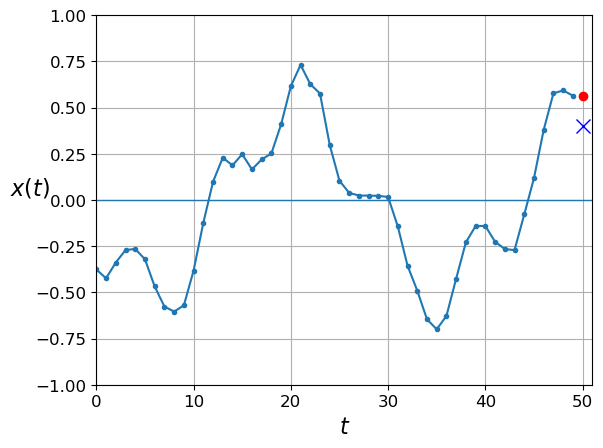

In [10]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 2.2 Linear Prediction - Perceptron

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

n_net = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

n_net.compile(
    loss="mse", 
    optimizer="adam", 
    metrics=[keras.metrics.RootMeanSquaredError()]
)
history = n_net.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall' defined at (most recent call last):
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-11-087e47e024bb>", line 14, in <module>
      history = n_net.fit(X_train, y_train, epochs=20,
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/nick/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall'
could not find registered platform with id: 0x11a6a7ee0
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_train_function_547]

In [9]:
mse, rmse = n_net.evaluate(X_valid, y_valid, verbose=0)
mse, rmse

(0.004112337499856949, 0.064127505)

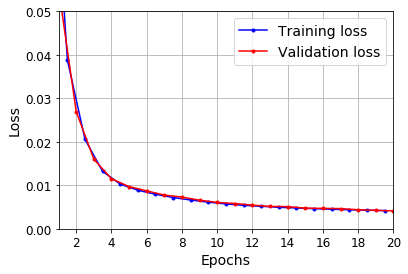

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

It looks  as if the system has been trained nicely. Let's see the predictions.

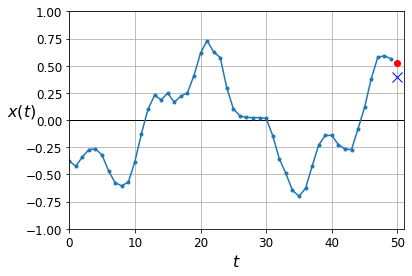

In [15]:
y_pred = n_net.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 2.3 A Simple RNN

This is really the simplest conceivable RNN. There is no need to specify the length of the input sequences here as an RNN can process any number of time points (hence the first input dimension is set to `None`). By default, the SimpleRNN layer uses the $tanh()$ activation functionn

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

n_net = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
n_net.compile(loss=keras.metrics.mean_squared_error, 
              optimizer=optimizer, 
              metrics=[keras.metrics.RootMeanSquaredError()])
history = n_net.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 944us/sample - loss: 0.0979 - root_mean_squared_error: 0.3129 - val_loss: 0.0490 - val_root_mean_squared_error: 0.2213
Epoch 2/20
7000/7000 [==============================] - 7s 983us/sample - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1723
Epoch 3/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1331
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0166 - root_mean_squared_error: 0.1290 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sa

In [20]:
mse, rmse = n_net.evaluate(X_valid, y_valid, verbose=0)
mse, rmse

(0.01090382856875658, 0.10442141)

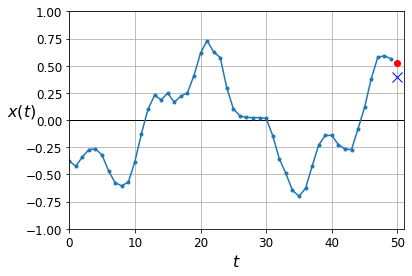

In [21]:
y_pred = n_net.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

This is better than the naive approach but not as good as the linear Perceptron model. However, not that for each neuron, a linear model has one parameter per input (i.e. per time step), plus a bias term (in our case, that was 51 parameters, but in general it would be $N_{time\_steps} + 1$). Coversely, for each recurrent neuron in the simple RNN, there’s 1 parameter per input and 1 per hidden state dimension  plus a bias term. In this  simple RNN there is just a neuron, hence 1 hidden state dimension: that’s a total of 3 parameters. That scales much better, for time series with thousands or millions of time points.



### 2.4 Deep RNNs

**Exercise 01:** create a neural network with 3 recurrent layers:
* two layers of 20 recurrent units each
* one output layer with the appropriate number of recurrent neurons

Compile the network setting the appropriate loss function, the Adam optimizer, and RMSE ad an additional metric. Then train the network for the same number of epochs as the previous models.

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

n_net = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

n_net.compile(loss=keras.metrics.mean_squared_error, 
              optimizer="adam", 
              metrics=[keras.metrics.RootMeanSquaredError()])
history = n_net.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0531 - root_mean_squared_error: 0.2304 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911
Epoch 2/20
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 3/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0738 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704
Epoch 4/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 5/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 6/20
7000/7000 [==============================] - 20s 3ms/sam

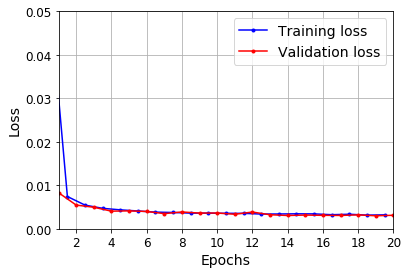

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

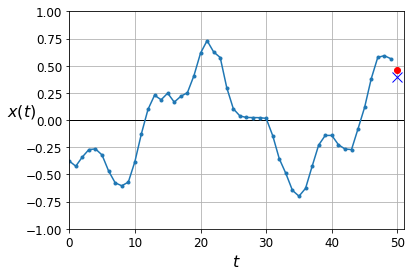

In [25]:
y_pred = n_net.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 3. Forecasting Several Steps Ahead

Until now we have only predicted the value at the next time step. Using the same network(s) we could have predicted values _n_ steps ahead just by changing the targets appropriately (e.g., to predict 10 steps ahead, change the targets to be the value 10 steps ahead instead of 1 step ahead). But what can we do if our goal is to predict the next _n_ values? There are basically two options here.

 1) use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the network again to predict the following value, and go on like this:

In [26]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = n_net.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [27]:
Y_pred.shape

(1, 10, 1)

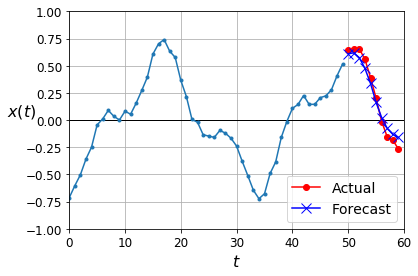

In [29]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

2) Train an RNN to predict all 10 next values at once. It is still possible to use a sequence-to-vector model, but this will produce 10 values instead of 1. For it to work we need to modify the targets to be vectors containing the next 10 values:

In [34]:
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now we need the output layer to have 10 units rather than 1:

In [35]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

**Exercise 02:** Compile and train the network defined above. Evaluate its performance